In [18]:
import torch
import torchaudio
import torchaudio.functional as F

import math
from IPython.display import Audio
import matplotlib.pyplot as plt

from torchaudio.utils import download_asset

In [19]:
SAMPLE_WAV = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.wav")
SAMPLE_RIR = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo-8000hz.wav")
SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")
SAMPLE_NOISE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo-8000hz.wav")

In [20]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [23]:
rir_raw, sample_rate = torchaudio.load(SAMPLE_RIR)
# extract the main impulse.
rir = rir_raw[:, int(sample_rate * 1.01) : int(sample_rate * 1.3)]

# normalize the signal power.
rir = rir / torch.norm(rir, p=2)

# flip along the time axis.
RIR = torch.flip(rir, [1])

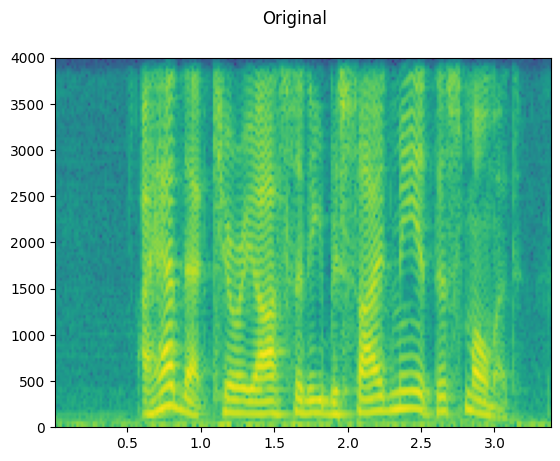

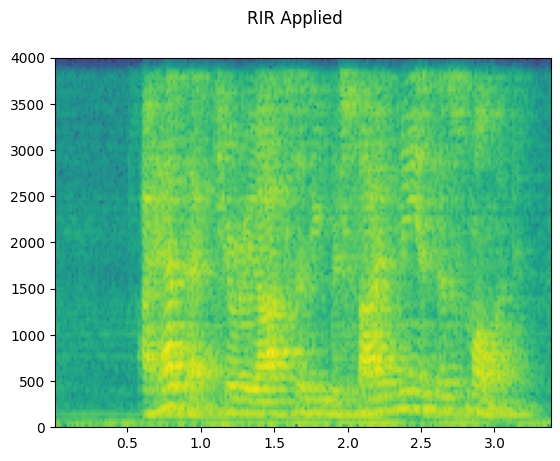

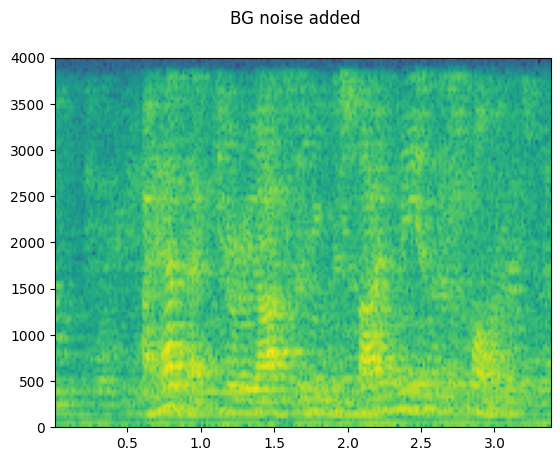

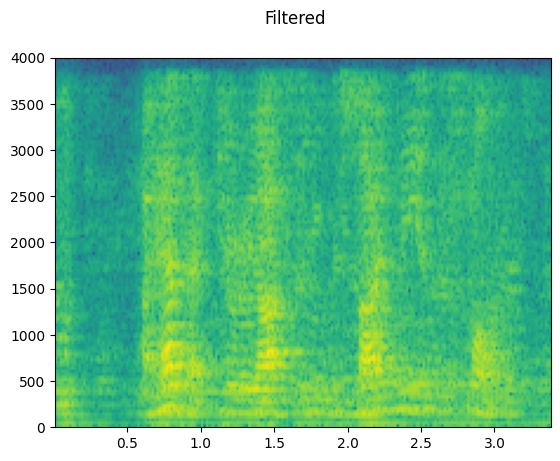

formats: gsm can't encode GSM to 16-bit


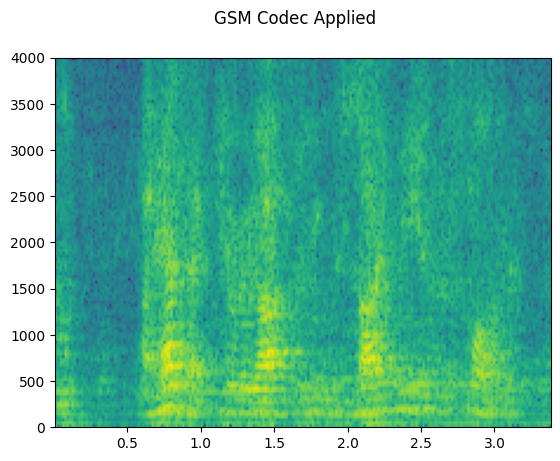

In [24]:
sample_rate = 16000
original_speech, sample_rate = torchaudio.load(SAMPLE_SPEECH)

plot_specgram(original_speech, sample_rate, title="Original")

# Apply RIR
speech_ = torch.nn.functional.pad(original_speech, (RIR.shape[1] - 1, 0))
rir_applied = torch.nn.functional.conv1d(speech_[None, ...], RIR[None, ...])[0]

plot_specgram(rir_applied, sample_rate, title="RIR Applied")

# Add background noise
# Because the noise is recorded in the actual environment, we consider that
# the noise contains the acoustic feature of the environment. Therefore, we add
# the noise after RIR application.
noise, _ = torchaudio.load(SAMPLE_NOISE)
noise = noise[:, : rir_applied.shape[1]]

snr_db = 8
scale = (10 ** (snr_db / 20)) * noise.norm(p=2) / rir_applied.norm(p=2)
bg_added = (scale * rir_applied + noise) / 2

plot_specgram(bg_added, sample_rate, title="BG noise added")

# Apply filtering and change sample rate
filtered, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(
    bg_added,
    sample_rate,
    effects=[
        ["lowpass", "4000"],
        [
            "compand",
            "0.02,0.05",
            "-60,-60,-30,-10,-20,-8,-5,-8,-2,-8",
            "-8",
            "-7",
            "0.05",
        ],
        ["rate", "8000"],
    ],
)

plot_specgram(filtered, sample_rate2, title="Filtered")

# Apply telephony codec
codec_applied = F.apply_codec(filtered, sample_rate2, format="gsm")

plot_specgram(codec_applied, sample_rate2, title="GSM Codec Applied")

# Original speech:

In [ ]:
Audio(original_speech, rate=sample_rate)

# RIR applied:

In [ ]:
Audio(rir_applied, rate=sample_rate)

# Background noise added:

In [ ]:
Audio(bg_added, rate=sample_rate)

# Filtered:

In [ ]:
Audio(filtered, rate=sample_rate2)

# Codec applied:

In [ ]:
Audio(codec_applied, rate=sample_rate2)